# 2: Power Outage Identification: Preprocessing and Word2Vec Model

### Contents:
- [Imports](#Imports)
- [Preprocessing](#Preprocessing)
- [Word2Vec Model](#Word2Vec-Model)
  * [Train Model](#Train-Model)
- [t-SNE Model Exploration](#t-SNE-Model-Exploration)  
  * [Visualization](#Visualization)
  * [Exporting Visual](#Exporting-Visual)
- [Evaluation](#Evaluation)  

## Imports

In [2]:
# Importing packages
from __future__ import absolute_import, division, print_function
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import codecs
import glob
import multiprocessing
import os
import pprint
import re
import nltk
from nltk.corpus import stopwords

#importing warning to turn off future warnings
import warnings
warnings.simplefilter(action='ignore')

## Preprocessing

Based on what we learned when reviewing our data in EDA, we set out to prepare the text for modeling by lower casing all words and removing punctuation and stopwords. We also removed complete url strings before tokenizing to make sure we captured all the url pieces, especially link shorteners. We printed out a sample tweet as it was altered to confirm that each step processed correctly.

In [3]:
#reading in the data
all_tweets_df = pd.read_csv('./datasets/combined_data.csv')
all_tweets_df.drop(columns='Unnamed: 0', inplace = True)
print(f'Shape of DataFrame: {all_tweets_df.shape}')
all_tweets_df.head()

Shape of DataFrame: (6670, 9)


id                                               text  \
0  973258558686027776  Power outage in the area causing delays. treat...   
1  901865645813399552  More wind and more rain in Austin today. Power...   
2  767159069186543616  South Austin outage partially restored. ~936 r...   
3  767122315947626496  Power outage in South Austin affecting ~3500 c...   
4  765714039594811392  Power outage affecting ~1,438 customers in the...   

             timestamp             user location   datestamp  \
0  2018-03-12 18:04:57  TotalTrafficAUS   Austin  2018-03-12   
1  2017-08-27 17:55:00        AusTxNerd   Austin  2017-08-27   
2  2016-08-21 00:39:09        Austin_CP   Austin  2016-08-21   
3  2016-08-20 22:13:07        Austin_CP   Austin  2016-08-20   
4  2016-08-17 00:57:07        Austin_CP   Austin  2016-08-17   

           date_place                combined_text  \
0  2018-03-12, Austin            dry, hot, cold ||   
1  2017-08-27, Austin      torrential, hot, hot ||   
2  2016-08-21, Austin  downpour, scorching, hot ||   
3  2016-08-20, Austin      torrential, hot, hot ||   
4  2016-08-17, Austin        downpour, hot, hot ||   

                                            all_text  
0  Power outage in the area causing delays. treat...  
1  More wind and more rain in Austin today. Power...  
2  South Austin outage partially restored. ~936 r...  
3  Power outage in South Austin affecting ~3500 c...  
4  Power outage affecting ~1,438 customers in the...

In [4]:
# create series just containing the text column
all_tweets = all_tweets_df['all_text']
print(f'Number of tweets: {len(all_tweets)}')

Number of tweets: 6670


In [5]:
# setting stopwords
stop_words = stopwords.words('english')

In [6]:
# Function to clean up tweets (removing urls, non-alphabetical characters)
def tweets_to_tweetlist(raw):
    clean = re.sub(r"[^a-zA-Z ]", "", raw)
    clean = re.sub(r"http.*?\b","",clean)
    clean = re.sub(r"pictwitter.*?\b","",clean)
    clean = re.sub(r"www.*?\b","",clean)
    clean = re.sub(r'instagramcom.*?\b','',clean)
    return clean

In [7]:
# Iterate through all_tweets, clean tweets and add to tweet_list
tweet_list = []
for tweet in all_tweets:
    tweet_list.append(tweets_to_tweetlist(tweet))
len(tweet_list)

6670

In [8]:
# Iterate through tweet_list convert to lowercase and tokenize each tweet
tokenized_tweet_list = [tweet.lower().split(' ') for tweet in tweet_list]   

In [9]:
# Remove stop words from tweets
# final_tweet_list is the version of our tweet list we will use from here on
final_tweet_list = []
for tweet in tokenized_tweet_list:
    word_list = []
    for word in tweet:
        if (word not in stop_words) & (word != ''):
            word_list.append(word)
    final_tweet_list.append(word_list)

In [10]:
#Seeing how many tweets we'll be working with
len(final_tweet_list)

6670

In [11]:
# Count number of words in tweets list (all tweets)
token_count = sum([len(tweet) for tweet in final_tweet_list])
print(f"The tweet list contains {token_count} tokens")

The tweet list contains 80066 tokens


In [12]:
# Compare different versions of tweets and see how they changed
def compare_tweets(n):    
    print(all_tweets[n]) # original version of nth tweet
    print()
    print(tweet_list[n]) # cleaned version of nth tweet
    print()
    print(tokenized_tweet_list[n]) # tokenized version of nth tweet
    print()
    print(final_tweet_list[n]) # tokenized version of nth tweet (stopwords removed)

In [13]:
#calling the first tweet 
compare_tweets(0)

Power outage in the area causing delays. treat as all way stop. in #Austin on Parmer Ln at Dessau Rd #ATXtraffic http://bit.ly/10BGKax , dry, hot, cold ||

Power outage in the area causing delays treat as all way stop in Austin on Parmer Ln at Dessau Rd ATXtraffic  dry hot cold 

['power', 'outage', 'in', 'the', 'area', 'causing', 'delays', 'treat', 'as', 'all', 'way', 'stop', 'in', 'austin', 'on', 'parmer', 'ln', 'at', 'dessau', 'rd', 'atxtraffic', '', 'dry', 'hot', 'cold', '']

['power', 'outage', 'area', 'causing', 'delays', 'treat', 'way', 'stop', 'austin', 'parmer', 'ln', 'dessau', 'rd', 'atxtraffic', 'dry', 'hot', 'cold']


## Word2Vec Model

We chose to use Word2Vec to model our data because of the way it focuses on the relationship of words and gives weight to that value. It maps the words from our dataset into a high dimensional space using a neural network. From that, we are able to train the model so that it can “learn” the conceptual relationship between words.  We wanted to use Word2Vec because it brings context of word choices into play, which will give us a better understanding of the group of words used in a tweet to talk about a power outage.  

In [14]:
# Instantiate Word2Vec model
tweets2vec = w2v.Word2Vec(
    sg = 1, # skip-gram train algo
    seed = 42, # Random Number Generator to make results repeatable
    workers = multiprocessing.cpu_count(), # number of threads
    size = 300, # Dimensionality of the hidden layer
    min_count = 3, # how many times the word has to appear to be kept in the vocab.
    window = 7, # size of the window to train words
    sample = 1e-5 # downsampling setting for frequent words
)

In [15]:
# Build tweets2vec vocabulary, haven't trained it yet, just loading it into memory
tweets2vec.build_vocab(final_tweet_list)

In [16]:
# how long is our tweets2vec vocabulary?
print("Tweets2Vec vocabulary length:", len(tweets2vec.wv.vocab))

Tweets2Vec vocabulary length: 2711


### Train Model

We trained our model on our tweet list so that it could "learn" the relationship of the words in the dataset.

In [17]:
# Train tweets2vec model on final_tweet_list
tweets2vec.train(final_tweet_list, total_examples=tweets2vec.corpus_count, epochs=tweets2vec.epochs)

(48846, 400330)

In [18]:
# Create directory to store our trained tweets2vec model in
if not os.path.exists("./datasets/training_model"):
    os.makedirs("./datasets/training_model")

In [19]:
# Save our trained tweets2vec model in the trained folder
tweets2vec.wv.save("./datasets/training_model/tweets2vec.w2v")

## t-SNE Model Exploration

While machines have no problem understanding high dimensional space, we needed to convert it back to two-dimensional space in order to examine and understand it. We used a t-SNE model for dimensionality reduction. 

Interpretability of t-SNE plots is not really intuitive right away. However what the plot is suppose to reveal is the relationships these words have to one another. Similar words or words that have a high probability appearing together will be close together in this plot while others without a positive relationship will appear further away. In the future we should consider running multiple versions of a t-SNE plot as each run, each parameter change, and each training session of the model can create a different plot with different interpretations. 

In [20]:
# reading in the trained data to explore it
tweets2vec = tweets2vec.wv.load("./datasets/training_model/tweets2vec.w2v")

In [21]:
# this is a word vector in 300 dimensional word space. We need to take it down a bit using TSNE
# That is t-distributed Stochastic Neighbor Embedding. Essentially it is a tool to visualize high-dimensional data.
# Takes a 300 dim vector and squashes it into 2 and derives coordinates from them.
# Here we are instantiating the t-SNE plot and establishing the parameters. 
tsne = sklearn.manifold.TSNE(n_components = 2, random_state = 42, perplexity= 70,learning_rate = 150,verbose =1,n_iter=5000)

In [22]:
# right now the tweets and their words are vectorized, converted into numbers. We need to convert them to word embeddings
# to start plotting them on the map in 2D.
all_word_vectors_matrix = tweets2vec.wv.syn0

In [23]:
# Training it will take some time...
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 2711 samples in 0.019s...
[t-SNE] Computed neighbors for 2711 samples in 3.621s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2711
[t-SNE] Computed conditional probabilities for sample 2000 / 2711
[t-SNE] Computed conditional probabilities for sample 2711 / 2711
[t-SNE] Mean sigma: 0.003696
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.428169
[t-SNE] KL divergence after 1800 iterations: 2.900101


In [24]:
#creating a dataframe of the t-SNE coordinates
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[tweets2vec.vocab[word].index])
            for word in tweets2vec.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [25]:
# Edited code from Boom Devahastin Na Ayudhya
# Define vectorization function
def vectorize_corpus(keyword_list):    
    
    # Instantiate counter for number of words in keyword_list that exists
    n_words = 0
    
    # Create template for cumulative corpus vector sum
    corpus_vec_sum = np.zeros((1,300))                 
    
    # Scan through each word in list
    for word in keyword_list:
        if word in tweets2vec.vocab:                    
            word_vec = tweets2vec.word_vec(word)        
            n_words +=1                                
            corpus_vec_sum = corpus_vec_sum + word_vec 

    # Compute average vector by taking cumulative vector sum and dividing it by number of words traced
    corpus_avg_vec = corpus_vec_sum/n_words
    
    # Squeeze this N-dimensional nested array object into a 1-D array to streamline future processing
    corpus_avg_vec = np.squeeze(corpus_avg_vec)
    
    return(corpus_avg_vec)

In [26]:
#defining cosine similarity function
def cos_sim(vector_1, vector_2):
    dp = np.dot(vector_1, vector_2)
    magnitude_v1 = np.sqrt(np.dot(vector_1,vector_1))
    magnitude_v2 = np.sqrt(np.dot(vector_2,vector_2))
    return(dp/(magnitude_v1*magnitude_v2))

To classify our tweets, we set up a list of positive and negative words for them to be compared to, using a cosine similarity score. The keyword lists were developed by exploring the dataset and extracting words that related more to power outages versus words that related to outages that were not power related. These included telecommunications outages as well as websites doing down such as Netflix or Facebook.

We edited this list as we fine tuned our model, watching for any misclassification word patterns.

In [27]:
#creating our pos/neg keyword lists 

# List of words for legitimate outages
power_out = ['generators','flooding','austinenergy','santaclarapower','grid', 'massive',
           'failure','generator','darkness','utoutage','powers','txuenergy','thunderstorms',
           'major', 'serious', 'surge', 'storm','storms','transformer','power','windstorm',
           'substation', 'alert', 'electrical', 'lights','thunderstorm','snake',
           'lightning','electricity','poweroutage','delays','atxoutage','nopower','lightsout',
           'candlelight','candle','candles','comed','coned','conedison','cnpalerts']

# List of words for non-legitimate outages (such as internet, Netflix, Facebook, or other service outages)
not_out = ['lines','whatsapp','aws','airworldwide','broadband','askspectrum','amtrack','dropbox',
               'twitter','skype','instagram','insta','espnfantasy','directv','netflix',
               'hulu', 'warner','microsoft','cable','tw','service','time',
               'twc','itunes','apple','attcares','attcustomercare','att','phones',
               'youtube','yt','facebook','centurylink','connectivity','network',
               'gmail','uverse', 'verizon', 'tmobile', 'phone', 'sprintcare',
               'sprint','wifi','internet', 'wireless', 'comcast','rcn','grandecom',
               'comcastcares','rcnconnects','playstation','sony','xfinity',
               'ig','fb','twchelp','nationwide','google','googlefiber','frontier','frontiercorp']

In [28]:
#vectorizing the keyword lists
power_out_vec = vectorize_corpus(power_out)
not_out_vec = vectorize_corpus(not_out)

In [29]:
#scoring words against our keywords
points['power_out_cs'] = [cos_sim(tweets2vec.word_vec(word),power_out_vec) for word in points['word']]
points['not_out_cs'] = [cos_sim(tweets2vec.word_vec(word),not_out_vec) for word in points['word']]
points['power_out_label'] = np.where(points['power_out_cs'] >= points['not_out_cs'],'power_out','not_out')
points.head()

word         x         y  power_out_cs  not_out_cs power_out_label
0    power  7.344934  0.923877      0.948935    0.943638       power_out
1   outage  7.344080  0.923790      0.945375    0.944922       power_out
2     area  7.032692  0.871563      0.819168    0.814102       power_out
3  causing  5.205840 -0.233145      0.559893    0.549609       power_out
4   delays  4.011348  0.041550      0.531169    0.520424       power_out

In [30]:
#getting the counts for each label
points['power_out_label'].value_counts()

not_out      1412
power_out    1299
Name: power_out_label, dtype: int64

In [31]:
#sorting to see what words appear up top for legitimate power outages
points[points['power_out_label'] == 'power_out'].sort_values(by = 'power_out_cs',ascending = False).head(10)

word         x         y  power_out_cs  not_out_cs power_out_label
0       power  7.344934  0.923877      0.948935    0.943638       power_out
1      outage  7.344080  0.923790      0.945375    0.944922       power_out
13        hot  7.342223  0.923838      0.945339    0.943130       power_out
93       warm  7.344615  0.923922      0.943958    0.941046       power_out
14       cold  7.319191  0.919709      0.933067    0.931467       power_out
91         im  7.136776  0.891241      0.871292    0.854679       power_out
16       rain  7.110138  0.885324      0.847386    0.843197       power_out
2        area  7.032692  0.871563      0.819168    0.814102       power_out
33  scorching  7.014444  0.868894      0.814965    0.807647       power_out
32   downpour  6.915000  0.853751      0.812647    0.809784       power_out

In [32]:
#seeing what the top are for not a legitamate power outage
points[points['power_out_label'] == 'not_out'].sort_values(by = 'not_out_cs',ascending = False).head(10)

word         x         y  power_out_cs  not_out_cs power_out_label
12          dry  7.338312  0.923719      0.929350    0.938016         not_out
321    freezing  7.203827  0.902273      0.884734    0.892849         not_out
22   torrential  7.162134  0.894057      0.877270    0.882208         not_out
45      without  7.148169  0.892373      0.863046    0.876547         not_out
68          get  7.094636  0.885660      0.836464    0.840600         not_out
752        line  6.920860  0.851253      0.809563    0.823633         not_out
270        work  6.924385  0.845758      0.791440    0.799083         not_out
35    customers  6.709078  0.810790      0.775352    0.782337         not_out
200    facebook  6.771268  0.831844      0.744287    0.781897         not_out
83     internet  6.663870  0.814109      0.763527    0.781179         not_out

In [33]:
#checking out what words are most similar to the word "power"
tweets2vec.most_similar("power", topn=10)

[('warm', 0.9639751315116882),
 ('hot', 0.9621654152870178),
 ('outage', 0.9581667184829712),
 ('dry', 0.9492332935333252),
 ('cold', 0.9411296844482422),
 ('freezing', 0.9087190628051758),
 ('torrential', 0.9008880853652954),
 ('without', 0.883340060710907),
 ('im', 0.87543785572052),
 ('rain', 0.8677214980125427)]

In [34]:
#checking out what words are most similar to the word "outage"
tweets2vec.most_similar("outage")

[('hot', 0.9610887765884399),
 ('warm', 0.9584839940071106),
 ('power', 0.9581667184829712),
 ('cold', 0.9490904211997986),
 ('dry', 0.947862982749939),
 ('freezing', 0.8983253240585327),
 ('torrential', 0.8975508213043213),
 ('without', 0.8904365301132202),
 ('im', 0.8754454851150513),
 ('get', 0.8556826114654541)]

In [35]:
#taking a look at each tweet with both scores so we can review what word groups were used to create the score
#this is helpful for fine tuning the model
for tweet in final_tweet_list:
    print(tweet)
    tweet_avg_vec = vectorize_corpus(tweet)
    print(f'Power Out CS: {cos_sim(tweet_avg_vec,power_out_vec)}')
    print(f'Not Out CS: {cos_sim(tweet_avg_vec,not_out_vec)}')

['power', 'outage', 'area', 'causing', 'delays', 'treat', 'way', 'stop', 'austin', 'parmer', 'ln', 'dessau', 'rd', 'atxtraffic', 'dry', 'hot', 'cold']
Power Out CS: 0.9542051775563722
Not Out CS: 0.9548329868435107
['wind', 'rain', 'austin', 'today', 'power', 'neighborhood', 'since', 'send', 'coffee', 'torrential', 'hot', 'hot']
Power Out CS: 0.9523534456748823
Not Out CS: 0.9523771911827087
['south', 'austin', 'outage', 'partially', 'restored', 'remain', 'wo', 'power', 'estimated', 'restoration', 'pm', 'cause', 'lightning', 'downpour', 'scorching', 'hot']
Power Out CS: 0.9525851741845551
Not Out CS: 0.9509754213909906
['power', 'outage', 'south', 'austin', 'affecting', 'customers', 'help', 'way', 'atxoutage', 'torrential', 'hot', 'hot']
Power Out CS: 0.9543283270756185
Not Out CS: 0.9569263797646322
['power', 'outage', 'affecting', 'customers', 'wells', 'branchpark', 'bendmopac', 'area', 'crews', 'en', 'route', 'atxoutage', 'downpour', 'hot', 'hot']
Power Out CS: 0.957257868525885
Not

Power Out CS: 0.954233785391843
Not Out CS: 0.9529046642291659
['power', 'outage', 'chicago', 'il', 'torrential', 'scorching', 'warm']
Power Out CS: 0.9560580758194532
Not Out CS: 0.9539866967578037
['really', 'bad', 'time', 'power', 'outage', 'quiet', 'first', 'time', 'year', 'baker', 'prints', 'downpour', 'warm', 'warm']
Power Out CS: 0.9534902850011873
Not Out CS: 0.954229494593829
['kevinsterk', 'comed', 'yeah', 'killing', 'sunday', 'right', 'state', 'elm', 'power', 'entire', 'se', 'side', 'downpour', 'warm', 'cold']
Power Out CS: 0.949243902557145
Not Out CS: 0.9441375712002915
['pay', 'much', 'money', 'outage', 'first', 'spring', 'ever', 'happen', 'chicago', 'rcnconnects', 'torrential', 'warm', 'cold']
Power Out CS: 0.9520464488607089
Not Out CS: 0.9522845260281214
['worker', 'injured', 'falling', 'power', 'lines', 'forest', 'park', 'without', 'power', 'dry', 'warm', 'cold']
Power Out CS: 0.9545189076649591
Not Out CS: 0.9551321340598602
['best', 'jjs', 'evermy', 'work', 'power',

Power Out CS: 0.9610324514849556
Not Out CS: 0.9544546392935768
['looks', 'like', 'power', 'halsted', 'looks', 'darker', 'usual', 'boystowntweets', 'lakeview', 'downpour', 'hot', 'warm']
Power Out CS: 0.9482364403418935
Not Out CS: 0.9446903347604924
['severe', 'storms', 'leave', 'thousands', 'without', 'power', 'residents', 'chicago', 'area', 'dark', 'downpour', 'hot', 'warm']
Power Out CS: 0.9582724173310789
Not Out CS: 0.9532510550611359
['comed', 'hours', 'without', 'power', 'south', 'evanston', 'time', 'frame', 'restored', 'downpour', 'hot', 'warm']
Power Out CS: 0.9538580588476709
Not Out CS: 0.9570608719988966
['lost', 'power', 'candles', 'sound', 'rain', 'downpour', 'hot', 'warm']
Power Out CS: 0.9549892867966921
Not Out CS: 0.9497033792300584
['tens', 'thousands', 'without', 'power', 'glenview', 'northbrook', 'park', 'ridge', 'torrential', 'hot', 'warm']
Power Out CS: 0.9539225160295247
Not Out CS: 0.9521341224095331
['powers', 'evanston', 'brilliant', 'torrential', 'hot', 'wa

['hell', 'power', 'rn', 'dry', 'warm', 'cold']
Power Out CS: 0.9540570419878248
Not Out CS: 0.954319381421828
['power', 'brunch', 'cap', 'city', 'grandview', 'rain', 'freezing', 'freezing']
Power Out CS: 0.9345539898498092
Not Out CS: 0.9348746359608335
['home', 'power', 'giving', 'interlockkit', 'generator', 'workout', 'works', 'fineblog', 'setup', 'downpour', 'scorching', 'warm']
Power Out CS: 0.9440343284701201
Not Out CS: 0.9419390187597273
['power', 'enas', 'still', 'gotta', 'get', 'fix', 'thestruggleisreal', 'enas', 'torrential', 'hot', 'warm']
Power Out CS: 0.9529385586954291
Not Out CS: 0.9519087691344437
['power', 'arrrrrrggghhhh', 'berzerker', 'nest', 'hilliard', 'oh', 'torrential', 'hot', 'warm']
Power Out CS: 0.9545632852684145
Not Out CS: 0.9527992615206691
['tuesday', 'storms', 'knock', 'power', 'american', 'electric', 'poweris', 'reporting', 'customers', 'without', 'power', 'franklin', 'torrential', 'hot', 'warm']
Power Out CS: 0.9586911280589878
Not Out CS: 0.9543615726

Not Out CS: 0.9534081844064577
['power', 'outage', 'baker', 'john', 'dr', 'dallas', 'tx', 'dry', 'hot', 'warm']
Power Out CS: 0.9569170062628765
Not Out CS: 0.9566266713251869
['askfrontier', 'fix', 'outage', 'lewisville', 'affecting', 'neighbors', 'torrential', 'hot', 'warm']
Power Out CS: 0.9504701985347077
Not Out CS: 0.951199843386427
['damaged', 'breaker', 'causes', 'power', 'outage', 'fine', 'arts', 'building', 'torrential', 'hot', 'warm']
Power Out CS: 0.9547947270890924
Not Out CS: 0.9517636593382512
['cant', 'show', 'power', 'uta', 'radio', 'dry', 'warm', 'cold']
Power Out CS: 0.9527390243828948
Not Out CS: 0.953940808073871
['power', 'arlington', 'car', 'crash', 'dry', 'hot', 'warm']
Power Out CS: 0.9549191931885515
Not Out CS: 0.9557927211346614
['police', 'crash', 'east', 'arlington', 'causes', 'power', 'outage', 'dry', 'hot', 'warm']
Power Out CS: 0.9567612270434382
Not Out CS: 0.9584946215914515
['oncor', 'report', 'streetlight', 'outage', 'torrential', 'warm', 'cold']
Po

Not Out CS: 0.9461920387844563
['power', 'outage', 'hail', 'thunder', 'lightning', 'month', 'old', 'torrential', 'scorching', 'warm']
Power Out CS: 0.9569636552353715
Not Out CS: 0.9524375602638555
['man', 'fuckin', 'power', 'torrential', 'scorching', 'warm']
Power Out CS: 0.95010334268157
Not Out CS: 0.9487493623325419
['wfaaweathertoo', 'lost', 'electricity', 'buckner', 'terrace', 'area', 'torrential', 'scorching', 'warm']
Power Out CS: 0.9460684208911072
Not Out CS: 0.9434037256352509
['knocked', 'power', 'torrential', 'scorching', 'warm']
Power Out CS: 0.951294493559804
Not Out CS: 0.9480567872155834
['lost', 'power', 'torrential', 'scorching', 'warm']
Power Out CS: 0.9511712152168139
Not Out CS: 0.9484915666008414
['kimmib', 'jeffgohogs', 'jojochanel', 'stlwrkr', 'mibfbi', 'nhdogmom', 'holy', 'shit', 'pouring', 'power', 'tornado', 'sirens', 'going', 'hail', 'torrential', 'scorching', 'warm']
Power Out CS: 0.9436207043872054
Not Out CS: 0.9373283584516487
['office', 'closed', 'earl

Power Out CS: 0.9559039287851354
Not Out CS: 0.9540165501996479
['wind', 'knock', 'power', 'downpour', 'hot', 'cold']
Power Out CS: 0.9552488469387272
Not Out CS: 0.9523024430557062
['storms', 'leave', 'michigan', 'without', 'electricity', 'jackson', 'officials', 'say', 'michigan', 'drizzle', 'hot', 'cold']
Power Out CS: 0.9406807694693421
Not Out CS: 0.9330138740933073
['high', 'winds', 'knock', 'power', 'thousands', 'southeast', 'michigan', 'detroit', 'wwj', 'high', 'winds', 'caused', 'thousands', 'rain', 'warm', 'cold']
Power Out CS: 0.9419905314396873
Not Out CS: 0.9406941190150478
['dte', 'truck', 'causes', 'outages', 'consumers', 'customers', 'east', 'grand', 'rapids', 'around', 'consumers', 'customers', 'lost', 'power', 'rain', 'warm', 'cold']
Power Out CS: 0.9487736762021027
Not Out CS: 0.9500166782058499
['coolin', 'trap', 'finna', 'dip', 'power', 'rain', 'warm', 'cold']
Power Out CS: 0.957450826992655
Not Out CS: 0.9529090767257652
['power', 'bull', 'even', 'storm', 'torrenti

Power Out CS: 0.9561443919516308
Not Out CS: 0.9542069584509945
['internet', 'outage', 'expected', 'last', 'hell', 'dry', 'hot', 'warm']
Power Out CS: 0.9531636010466759
Not Out CS: 0.9561507718896975
['lost', 'power', 'guys', 'housewtf', 'dude', 'torrential', 'hot', 'warm']
Power Out CS: 0.9552873768318672
Not Out CS: 0.9516407612332111
['earlier', 'called', 'saying', 'power', 'outage', 'turns', 'didnt', 'pay', 'light', 'billoh', 'things', 'residents', 'say', 'downpour', 'hot', 'warm']
Power Out CS: 0.9531449941834738
Not Out CS: 0.9526130225080238
['crews', 'restore', 'power', 'lost', 'power', 'severe', 'weather', 'metro', 'detroit', 'dte', 'energy', 'co', 'reporting', 'downpour', 'hot', 'warm']
Power Out CS: 0.9554712821973754
Not Out CS: 0.9538836933343776
['thousands', 'remain', 'without', 'power', 'days', 'severe', 'storms', 'detroit', 'wwj', 'power', 'restoredto', 'downpour', 'hot', 'warm']
Power Out CS: 0.9578195273195542
Not Out CS: 0.9546331669884092
['get', 'massive', 'storm

Power Out CS: 0.9554483741894202
Not Out CS: 0.9530731278766991
['damn', 'damn', 'damn', 'power', 'outage', 'race', 'motogp', 'dry', 'scorching', 'hot']
Power Out CS: 0.9511107130987145
Not Out CS: 0.9475725881748586
['comcastcaresmobilecarexvcable', 'internet', 'stoney', 'brook', 'apts', 'anyone', 'else', 'report', 'outage', 'dry', 'scorching', 'hot']
Power Out CS: 0.9500387911002235
Not Out CS: 0.9549539541919831
['power', 'lost', 'galvestons', 'pleasure', 'tier', 'authorities', 'say', 'know', 'caused', 'power', 'outage', 'dry', 'scorching', 'hot']
Power Out CS: 0.9571162280338773
Not Out CS: 0.9542838247530899
['theres', 'silence', 'solitude', 'think', 'power', 'outage', 'occurs', 'mind', 'dry', 'scorching', 'hot']
Power Out CS: 0.9567441752979304
Not Out CS: 0.9538487959323247
['power', 'trinity', 'house', 'dry', 'scorching', 'hot']
Power Out CS: 0.9530584256799414
Not Out CS: 0.9525159743321827
['water', 'main', 'break', 'causes', 'hourslong', 'water', 'outage', 'hobby', 'airport'

Not Out CS: 0.9527439608079327
['power', 'yas', 'torrential', 'warm', 'warm']
Power Out CS: 0.9527877388399177
Not Out CS: 0.950256638828724
['getting', 'ready', 'without', 'power', 'difficult', 'noshowerwednesday', 'cc', 'coreyxlyn', 'drizzle', 'hot', 'warm']
Power Out CS: 0.9517002806068571
Not Out CS: 0.9483664135292972
['truck', 'accident', 'leaves', 'hundreds', 'without', 'power', 'nj', 'hundreds', 'people', 'without', 'power', 'truck', 'accident', 'dry', 'hot', 'cold']
Power Out CS: 0.9514564473505114
Not Out CS: 0.9530211093825106
['power', 'reason', 'dry', 'hot', 'warm']
Power Out CS: 0.9563725121363956
Not Out CS: 0.9562418310045359
['adamfurlong', 'datpat', 'yeah', 'look', 'need', 'place', 'swim', 'tonight', 'though', 'power', 'outage', 'friends', 'select', 'dry', 'hot', 'warm']
Power Out CS: 0.9539166044281908
Not Out CS: 0.9563681999719696
['lost', 'power', 'back', 'theres', 'noisy', 'helicopter', 'basically', 'ready', 'land', 'house', 'goaway', 'ineedsleep', 'dry', 'hot', 

Power Out CS: 0.9442690031436018
Not Out CS: 0.9484932945381875
['chestnut', 'hill', 'without', 'power', 'im', 'fool', 'traveling', 'chestnut', 'hill', 'torrential', 'cold', 'freezing']
Power Out CS: 0.9493503685509302
Not Out CS: 0.9441657065381369
['abc', 'updatevillanova', 'university', 'closed', 'rest', 'week', 'due', 'outage', 'reason', 'hate', 'torrential', 'cold', 'freezing']
Power Out CS: 0.9441320990420348
Not Out CS: 0.9450514831373329
['villanova', 'university', 'closed', 'friday', 'due', 'power', 'heat', 'outage', 'philadelphia', 'cbsaccording', 'torrential', 'cold', 'freezing']
Power Out CS: 0.9548900291874752
Not Out CS: 0.9564727189171327
['going', 'buy', 'batteries', 'logs', 'fire', 'footsie', 'pajamas', 'endure', 'night', 'without', 'power', 'freezing', 'temperatures', 'torrential', 'cold', 'freezing']
Power Out CS: 0.9462134156285439
Not Out CS: 0.9484476240908105
['narberth', 'borough', 'hall', 'remain', 'open', 'warming', 'charging', 'station', 'pm', 'without', 'pow

Power Out CS: 0.9530122418583628
Not Out CS: 0.9545779074221427
['askspectrum', 'service', 'outage', 'dry', 'hot', 'warm']
Power Out CS: 0.9551555694389694
Not Out CS: 0.9589403517313282
['thanks', 'ladwp', 'getting', 'block', 'berendo', 'back', 'working', 'ice', 'cream', 'melted', 'well', 'live', 'appreciate', 'twitter', 'updates', 'lawind', 'poweroutage', 'dry', 'hot', 'warm']
Power Out CS: 0.9454979106831196
Not Out CS: 0.9492819328106298
['power', 'outage', 'tarzana', 'dry', 'hot', 'warm']
Power Out CS: 0.9595551815171731
Not Out CS: 0.9588089770761057
['ladwp', 'customers', 'remain', 'without', 'power', 'amid', 'high', 'winds', 'toppled', 'trees', 'across', 'southland', 'kabctv', 'via', 'googlenews', 'dry', 'hot', 'warm']
Power Out CS: 0.9518501423270627
Not Out CS: 0.955688542783577
['currently', 'sitting', 'candlelight', 'watching', 'henrylouisgates', 'findingyourroots', 'iphone', 'eating', 'chipotle', 'hadnt', 'seen', 'burrito', 'made', 'would', 'honestly', 'know', 'looks', 'li

Power Out CS: 0.9549432125797462
Not Out CS: 0.9499814152100556
['coxhelp', 'outage', 'gilbert', 'az', 'area', 'dry', 'scorching', 'hot']
Power Out CS: 0.9478998804641533
Not Out CS: 0.949844954474873
['power', 'tempe', 'history', 'museum', 'vihel', 'pyle', 'centers', 'activities', 'canceled', 'power', 'outage', 'forced', 'dry', 'scorching', 'hot']
Power Out CS: 0.9569251712738178
Not Out CS: 0.9551618098432537
['microburst', 'slams', 'wittmann', 'without', 'power', 'microburst', 'pounded', 'wittmann', 'monday', 'evening', 'knocking', 'dry', 'scorching', 'hot']
Power Out CS: 0.9449536800943249
Not Out CS: 0.9514019351938716
['without', 'power', 'southern', 'az', 'tucson', 'electric', 'power', 'customers', 'without', 'across', 'dry', 'scorching', 'hot']
Power Out CS: 0.9525660935961965
Not Out CS: 0.9553235866792545
['surviving', 'summer', 'power', 'outage', 'surviving', 'power', 'outage', 'summertime', 'valley', 'challenge', 'rain', 'scorching', 'hot']
Power Out CS: 0.9534830481178652


['underground', 'electrical', 'explosion', 'leaves', 'gaslamp', 'marriott', 'without', 'power', 'forces', 'evacuations', 'street', 'closures', 'drizzle', 'warm', 'cold']
Power Out CS: 0.9493920077667933
Not Out CS: 0.9462855269322072
['power', 'outage', 'la', 'mesa', 'california', 'dry', 'hot', 'warm']
Power Out CS: 0.958337746196339
Not Out CS: 0.9580577764769411
['psa', 'power', 'outage', 'naval', 'amphibious', 'base', 'coronado', 'dry', 'hot', 'warm']
Power Out CS: 0.9567551565830229
Not Out CS: 0.9574310126987061
['carlsbad', 'la', 'costa', 'residents', 'lose', 'power', 'sept', 'power', 'outage', 'mondayleft', 'dry', 'hot', 'warm']
Power Out CS: 0.9568662122378427
Not Out CS: 0.9574190215633472
['oh', 'man', 'dr', 'zombies', 'fight', 'neon', 'mix', 'tape', 'tour', 'impossible', 'without', 'power', 'ups', 'pvz', 'dry', 'hot', 'warm']
Power Out CS: 0.9540808005699712
Not Out CS: 0.9557782971797637
['authorities', 'search', 'cause', 'weekend', 'outage', 'san', 'diego', 'county', 'auth

Power Out CS: 0.9362465964184411
Not Out CS: 0.9451172565864626
['resolved', 'connectivity', 'issues', 'tipbot', 'fully', 'operational', 'outage', 'lasted', 'minutes', 'dry', 'warm', 'cold']
Power Out CS: 0.9518803732673823
Not Out CS: 0.9476385902513091
['power', 'phone', 'mmm', 'dry', 'warm', 'cold']
Power Out CS: 0.956203657068502
Not Out CS: 0.9600830613369308
['airpower', 'isnt', 'yet', 'time', 'waiting', 'airpower', 'days', 'hours', 'minutes', 'dry', 'warm', 'cold']
Power Out CS: 0.9362465964184411
Not Out CS: 0.9451172565864626
['sadly', 'airpower', 'yet', 'time', 'waiting', 'airpower', 'days', 'hours', 'minutes', 'dry', 'warm', 'cold']
Power Out CS: 0.9389380331319506
Not Out CS: 0.9456761042800337
['airpower', 'yet', 'time', 'waiting', 'airpower', 'days', 'hours', 'minutes', 'dry', 'warm', 'cold']
Power Out CS: 0.938131341299544
Not Out CS: 0.9461484606402776
['companies', 'lost', 'data', 'center', 'days', 'outage', 'filed', 'bankruptcy', 'within', 'year', 'disaster', 'datacen

In [36]:
#creating a dataframe of the scores, including noting areas of blackout
all_tweets_df['score_power_out']     = [cos_sim(vectorize_corpus(tweet),power_out_vec) for tweet in final_tweet_list]
all_tweets_df['score_not_out'] = [cos_sim(vectorize_corpus(tweet),not_out_vec) for tweet in final_tweet_list]
all_tweets_df['blackout']  = np.where(all_tweets_df['score_power_out'] >= all_tweets_df['score_not_out'],'power_out','not_out')
all_tweets_df.head()

id                                               text  \
0  973258558686027776  Power outage in the area causing delays. treat...   
1  901865645813399552  More wind and more rain in Austin today. Power...   
2  767159069186543616  South Austin outage partially restored. ~936 r...   
3  767122315947626496  Power outage in South Austin affecting ~3500 c...   
4  765714039594811392  Power outage affecting ~1,438 customers in the...   

             timestamp             user location   datestamp  \
0  2018-03-12 18:04:57  TotalTrafficAUS   Austin  2018-03-12   
1  2017-08-27 17:55:00        AusTxNerd   Austin  2017-08-27   
2  2016-08-21 00:39:09        Austin_CP   Austin  2016-08-21   
3  2016-08-20 22:13:07        Austin_CP   Austin  2016-08-20   
4  2016-08-17 00:57:07        Austin_CP   Austin  2016-08-17   

           date_place                combined_text  \
0  2018-03-12, Austin            dry, hot, cold ||   
1  2017-08-27, Austin      torrential, hot, hot ||   
2  2016-08-21, Austin  downpour, scorching, hot ||   
3  2016-08-20, Austin      torrential, hot, hot ||   
4  2016-08-17, Austin        downpour, hot, hot ||   

                                            all_text  score_power_out  \
0  Power outage in the area causing delays. treat...         0.954205   
1  More wind and more rain in Austin today. Power...         0.952353   
2  South Austin outage partially restored. ~936 r...         0.952585   
3  Power outage in South Austin affecting ~3500 c...         0.954328   
4  Power outage affecting ~1,438 customers in the...         0.957258   

   score_not_out   blackout  
0       0.954833    not_out  
1       0.952377    not_out  
2       0.950975  power_out  
3       0.956926    not_out  
4       0.954818  power_out

In [37]:
#checking out counts for blackout
all_tweets_df['blackout'].value_counts()

power_out    3486
not_out      3184
Name: blackout, dtype: int64

In [38]:
#saving the csv
all_tweets_df.to_csv('./datasets/final_scored_data.csv')

## Visualization

The t-SNE plot lets us explore our dataset words visually. The words in blue represent the power being out, while gray words are associated with it not being a legitimate power outage.

In [39]:
#setting context style
sns.set_context("poster")

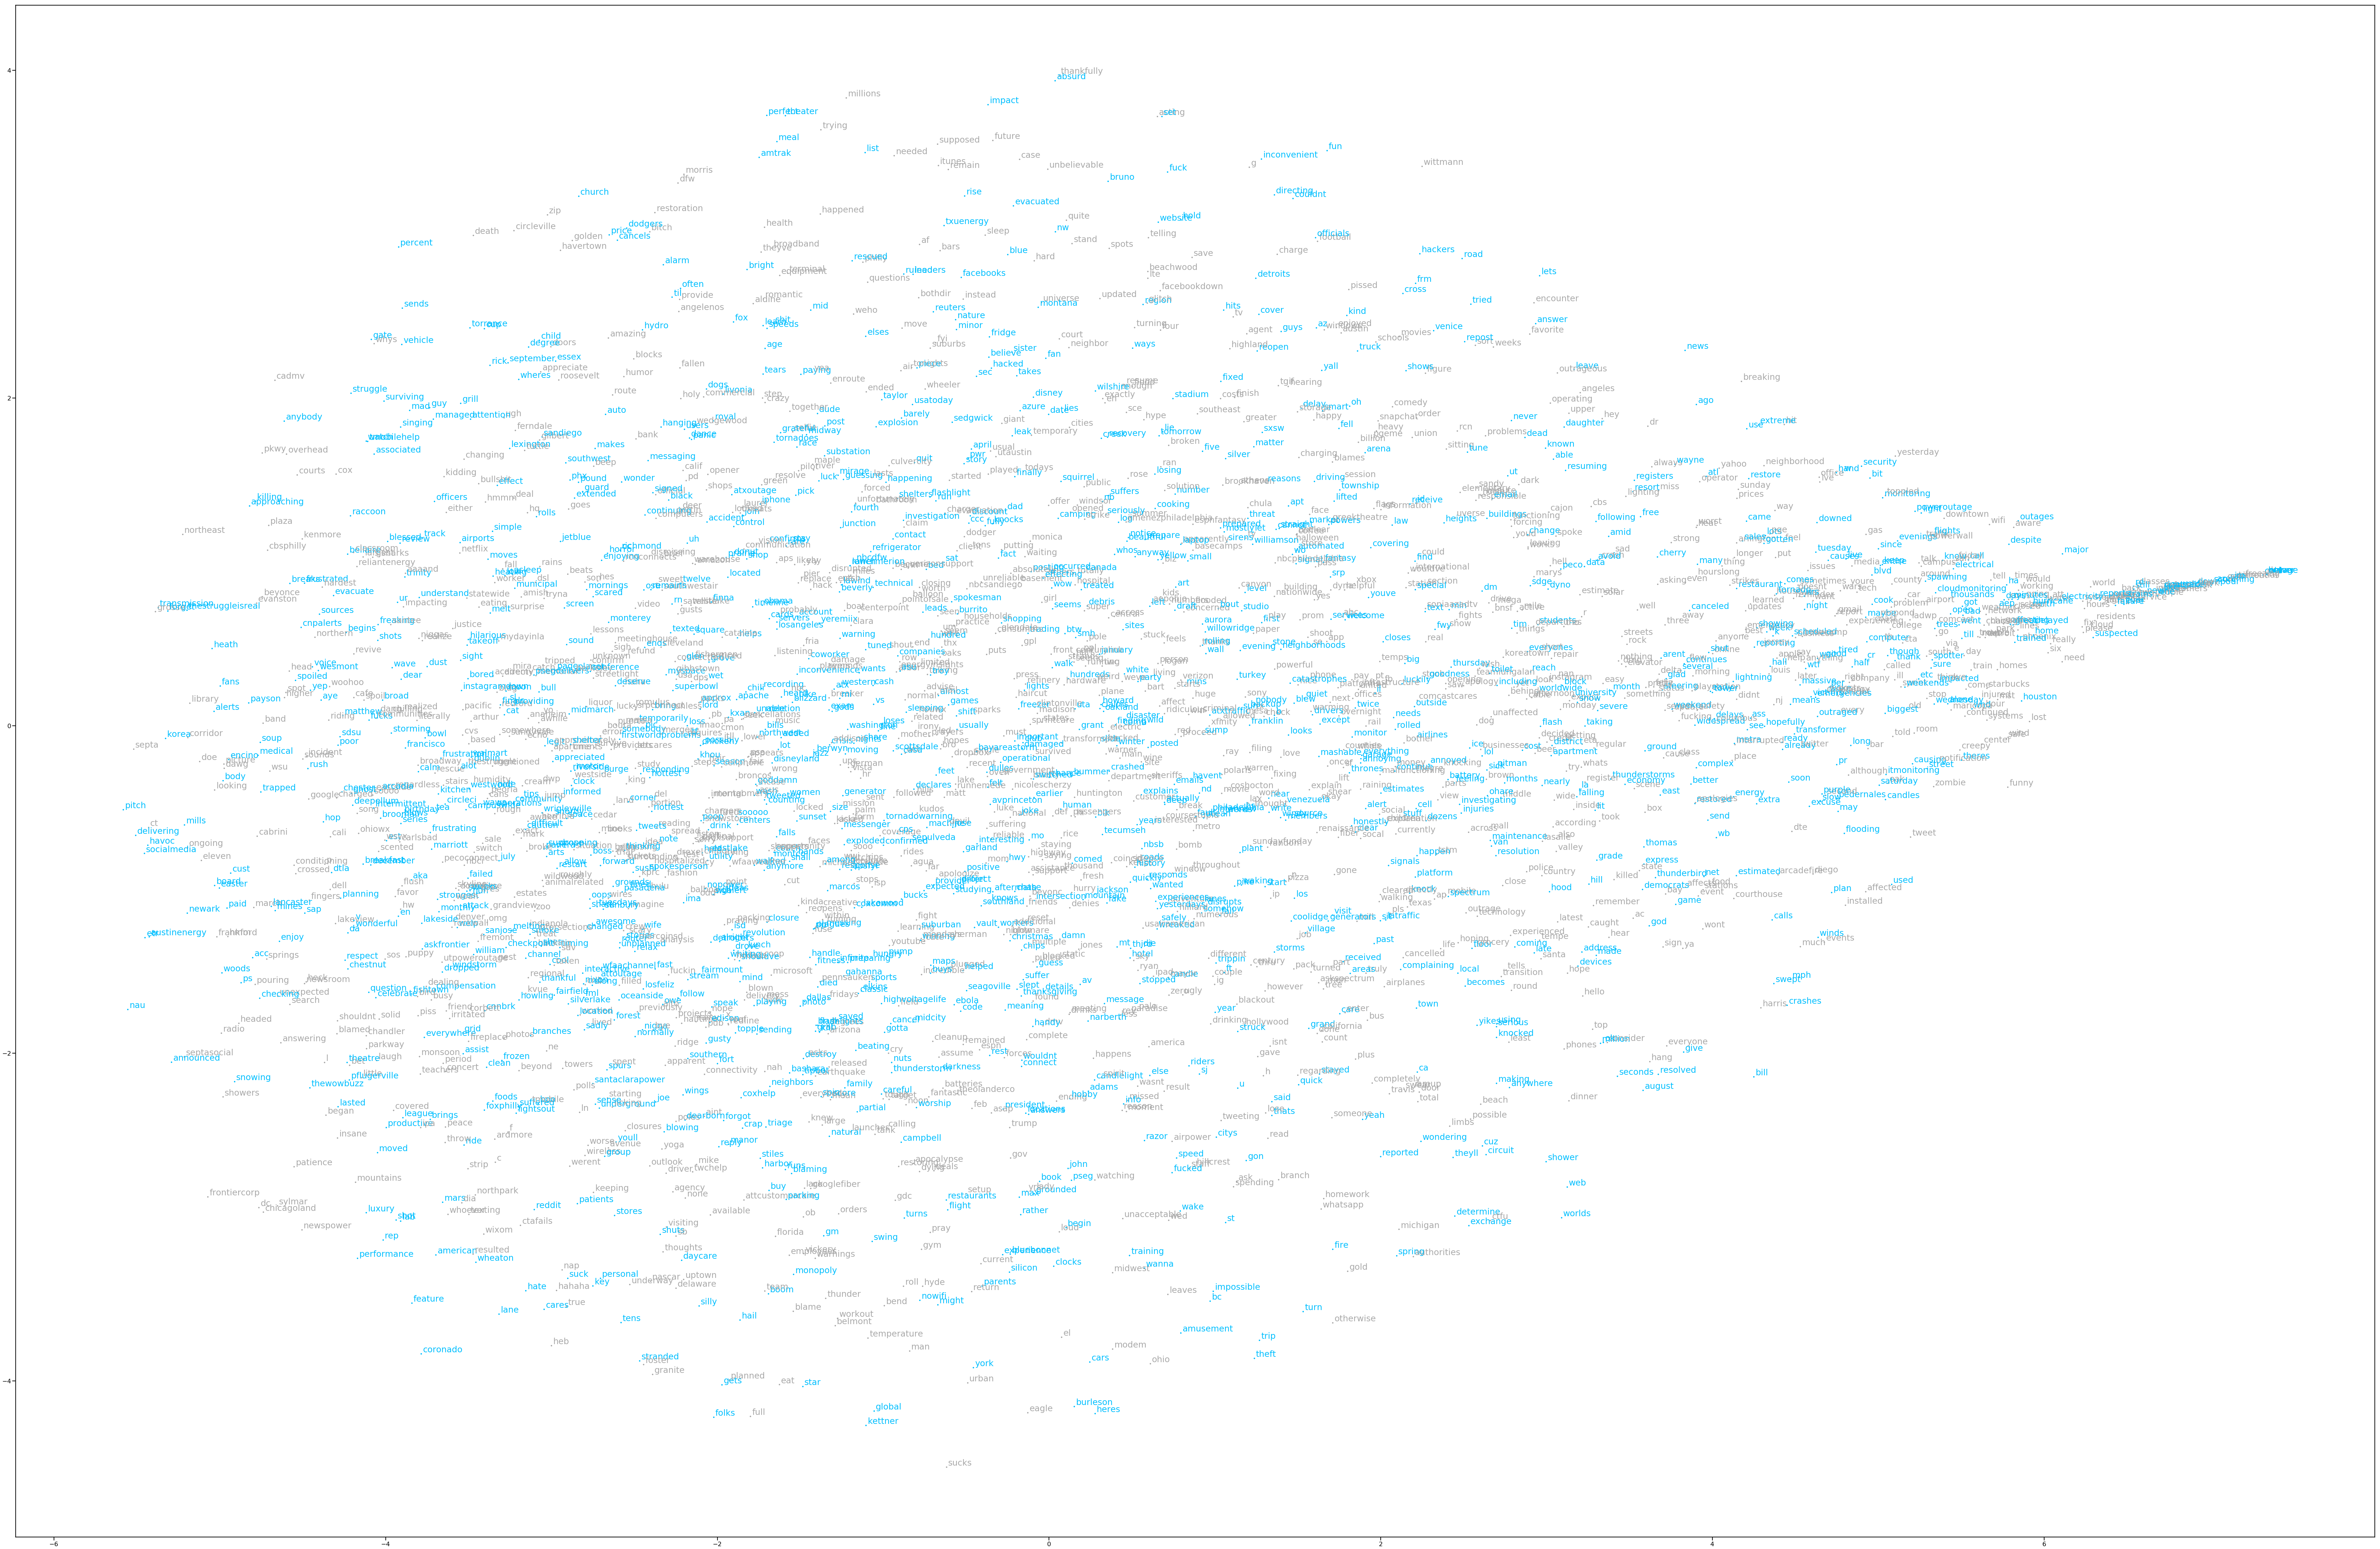

In [40]:
#plotting the t-SNE
plt.figure(figsize = (150,100))
colors = {'power_out':'deepskyblue', 'not_out':'darkgrey'}
for i,word in enumerate(points['word']):
    x = points['x'][i]
    y = points['y'][i]
    color = points['power_out_label'].apply(lambda x: colors[x])[i]
    plt.scatter(x, y, color=color, s = 10)
    plt.text(x+0.01, y+0.01, word,color = color, fontsize=30)
plt.show()

# to see the plot please zoom in. 

## Exporting Visual

This code will create and export an html file that will allow you to interact with the visual plot. The dots in blue represent the power being out, while gray dots are associated with it not being a legitimate power outage. The size of the dot also shows us how high it’s cosine similarity score is. Larger dots have larger scores, meaning a stronger relationship to either the positive or negative word list.

In [41]:
#creating and exporting an html file of the t-SNE plot

import numpy as np

from bokeh.plotting import figure, show, output_file,ColumnDataSource

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

source = ColumnDataSource(data = dict(
    x = points['x'],
    y = points['y'],
    label = points['power_out_label'],
    power_out_cs = points['power_out_cs'],
    not_out_cs = points['not_out_cs'],
    radii = ((points['power_out_cs']*points['power_out_label'].apply(lambda x: 1 if (x == 'power_out') else 0))+(points['not_out_cs']*points['power_out_label'].apply(lambda x: 0 if (x == 'power_out') else 1)))*0.25,
    color = points['power_out_label'].apply(lambda x: colors[x]),
    words = points['word']
))
TOOLTIPS =[
    ('word', '@words'),
    ('class','@label'),
    ('power out cos sim','@power_out_cs'),
    ('not out cos sim','@not_out_cs')
]
p = figure(title = 't-SNE Plot of Words in Tweets',
           tooltips=TOOLTIPS)

p.scatter('x', 'y', radius='radii', source = source,
          fill_color='color', line_color = None, fill_alpha=0.3)

output_file("./visualizations/tsne_scatter.html", title="tsne_scatter.py")

show(p)  # open a browser

## Evaluation

To evaluate our model’s performance, we had to manually confirm whether or not it was classified correctly. Ideally, we’d be able to go through all the tweets to confirm this but we ran out of time. We reviewed one thousand tweets and found six misclassifications. We’d need to review more to confirm whether this is what to expect in terms of number of misclassifications or an anomaly. From there we’d need to fine tune the model to lessen misclassifications. 

When we started this process, we believed that weather played a large role in power outages, and it does. However, we also discovered that the word “snakes” related high for flagging legitimate power outages. And that’s how we learned that snakes can climb into transformers and cause power outages. 

**Please continue to [3_Outage_Map_and_Next_Steps.ipynb](./3_Outage_Map_and_Next_Steps.ipynb) for the next step in the project: Outage Map**